# Task: An analysis of how similar the weather is between 2 locations of your choice
- There should be at least 500 kms between the two locations and they could be at opposite sides of the planet
- Come up with 2-3 hypotheses before doing the analysis
- examples:
    - I assert that if it is raining in Edinburgh, then it also usually rains in Paris, so that I can book my summer holiday when it's dry in Edinburgh. 
    - I assert that winters in Edinburgh are not colder than winters in Berlin, so that I can grow the same perennial plants I used to grow in Berlin.  
- Produce some evidence to argue that this hypothesis is correct or wrong.
- At the end you should phrase your conclusion in layman's terms, so that a non-technical audience can understand them. 

- Data: World Weather Online or Meteomatics

In [1]:
import requests
import calendar
from datetime import date
import pandas as pd

## World Weather Online

In [1]:
import requests

In [2]:
BASE_URL = "https://api.worldweatheronline.com/premium/v1/past-weather.ashx"
# configuration: store api key in a text file named wwoapikey.txt
API_KEY = open('wwoapikey.txt', 'r').read()

In [3]:
def format_query(location, start_date, end_date):
    """
    format API request query
    provide required params: 
        q - location
        key - api key
        date - date/ start date for a period
    optional params:
        format - output format (XML / JSON)
        tp - time interval
            (options are: 1 hour, 3 hourly, 6 hourly, 12 hourly (day/night) or 24 hourly (day average))
    """
    query = {
        "q": location,
        "key": API_KEY,
        "date": start_date,
        "enddate": end_date,
        "format": "JSON",
        "tp": 24,
    }
    return query

In [4]:
def get_data(url, params):
    response = requests.get(url, params=params)
    return response.json()

### Response
- data
    - weather
        - maxtempC
        - mintempC
        - avgtempC
        - hourly (24 hr average)
            - precipMM

Example response:
{'data': {'request': [{'type': 'City', 'query': 'Paris, France'}],
  'weather': [{'date': '2010-01-01',
    'astronomy': [{'sunrise': '09:44 AM',
      'sunset': '06:04 PM',
      'moonrise': '07:05 PM',
      'moonset': '10:19 AM',
      'moon_phase': 'Full Moon',
      'moon_illumination': '100'}],
    'maxtempC': '1',
    'maxtempF': '33',
    'mintempC': '-1',
    'mintempF': '31',
    'avgtempC': '0',
    'avgtempF': '32',
    'totalSnow_cm': '0.6',
    'sunHour': '6.9',
    'uvIndex': '1',
    'hourly': [{'time': '24',
      'tempC': '1',
      'tempF': '33',
      'windspeedMiles': '11',
      'windspeedKmph': '18',
      'winddirDegree': '257',
      'winddir16Point': 'WSW',
      'weatherCode': '332',
      'weatherIconUrl': [{'value': 'http://cdn.worldweatheronline.com/images/wsymbols01_png_64/wsymbol_0020_cloudy_with_heavy_snow.png'}],
      'weatherDesc': [{'value': 'Moderate snow'}],
      'precipMM': '0.7',
      'precipInches': '0.0',
      'humidity': '83',
      'visibility': '7',
      'visibilityMiles': '4',
      'pressure': '1001',
      'pressureInches': '30',
      'cloudcover': '68',
      'HeatIndexC': '-0',
      'HeatIndexF': '32',
      'DewPointC': '-3',
      'DewPointF': '27',
      'WindChillC': '-5',
      'WindChillF': '23',
      'WindGustMiles': '15',
      'WindGustKmph': '25',
      'FeelsLikeC': '-5',
      'FeelsLikeF': '23',
      'uvIndex': '1'}]},
   ...

In [5]:
# helper functions

def format_monthly_weather_summary(weather_data):
    """
    Returns the monthly weather summary in a list
    """
    return [extract_weather_params(daily_data) for daily_data in weather_data["data"]["weather"]]

In [6]:
def extract_weather_params(daily_data):
    """
    Extract key weather information:
        - maxtempC
        - mintempC
        - avgtempC
        - hourly (24 hr average)
            - precipMM * 24 => daily precipMM
    """
    return {
        "date": daily_data["date"],
        "max_temp_C": float(daily_data["maxtempC"]),
        "min_temp_C": float(daily_data["mintempC"]),
        "avg_temp_C": float(daily_data["avgtempC"]),
        "precip_mm": float(daily_data["hourly"][0]["precipMM"]),
    }

## Date
- year range: 2010-2020
- month: 1-12

In [7]:
import calendar
from datetime import date

In [8]:
def get_monthrange(year, month):
    month_end = calendar.monthrange(year, month)[1]
    start = date(year, month, 1).isoformat()
    end = date(year, month, month_end).isoformat()
    return (start, end)

## Pandas

### Download data

In [2]:
import pandas as pd

In [3]:
cities = ["paris", "berlin", "edinburgh"]

In [4]:
def format_city_data(city):
    """
    Returns a pandas dataframe for weather in a city during a 10 year period
    """
    df = pd.DataFrame()
    # loop through months of a 10 year period
    for year in range(2010, 2021):
        for month in range(1, 13):
            print(f"Getting data in: city: {city}, year: {year}, month: {month}")
            month_start, month_end = get_monthrange(year, month)
            query = format_query(city, month_start, month_end)
            data = get_data(BASE_URL, query)
            monthly_data = format_monthly_weather_summary(data)
            df = pd.concat([df, pd.DataFrame(monthly_data).set_index("date")])
            
    return df

In [5]:
def save_data(city):
    df = format_city_data(city)
    filename = f"{city}.csv"
    df.to_csv(filename)
    print("-----------------------")
    print(f"Data saved to {filename}")
    print("-----------------------")

In [6]:
for city in cities:
    save_data(city)

Getting data in: city: paris, year: 2010, month: 1


NameError: name 'get_monthrange' is not defined

## Weather analysis

In [7]:
# Load city dataframes
def load_df(city):
    df = pd.read_csv(f"{city}.csv")
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)
    return df

paris_df = load_df("paris")
edinburgh_df = load_df("edinburgh")
berlin_df = load_df("berlin")

In [8]:
paris_df

,max_temp_C,min_temp_C,avg_temp_C,precip_mm
date,,,,
2010-01-01,1.0,-1.0,0.0,0.7
2010-01-02,3.0,-1.0,1.0,0.2
2010-01-03,4.0,-3.0,1.0,0.0
2010-01-04,1.0,-5.0,-2.0,0.0
2010-01-05,-0.0,-6.0,-3.0,0.1
...,...,...,...,...
2020-12-27,8.0,3.0,7.0,27.6
2020-12-28,5.0,4.0,5.0,6.4
2020-12-29,5.0,-0.0,4.0,10.4


In [9]:
dates = paris_df.index

In [10]:
"""
Hypothesis 1: 
I assert that if it is raining in Edinburgh, 
then it also usually rains in Paris, 
so that I can book my summer holiday when it's dry in Edinburgh. 
"""

"\nHypothesis 1: \nI assert that if it is raining in Edinburgh, \nthen it also usually rains in Paris, \nso that I can book my summer holiday when it's dry in Edinburgh. \n"

In [11]:
paris_rained = paris_df["precip_mm"] > 1
edinburgh_rained = edinburgh_df["precip_mm"] > 1

In [12]:
hypo1_df = pd.DataFrame({"date": dates, "paris_rained": paris_rained, "edinburgh_rained": edinburgh_rained}).set_index("date")

In [13]:
hypo1_df["rained_in_both_cities"] = hypo1_df["edinburgh_rained"] & hypo1_df["paris_rained"]

In [14]:
hypo1_df["rained_in_edinburgh_and_paris"] = hypo1_df["edinburgh_rained"] & hypo1_df["paris_rained"]

In [15]:
hypo1_df

,paris_rained,edinburgh_rained,rained_in_both_cities,rained_in_edinburgh_and_paris
date,,,,
2010-01-01,False,True,False,False
2010-01-02,False,True,False,False
2010-01-03,False,False,False,False
2010-01-04,False,False,False,False
2010-01-05,False,True,False,False
...,...,...,...,...
2020-12-27,True,True,True,True
2020-12-28,True,True,True,True
2020-12-29,True,False,False,False


In [16]:
hypo1_df.describe()

,paris_rained,edinburgh_rained,rained_in_both_cities,rained_in_edinburgh_and_paris
count,4018,4018,4018,4018
unique,2,2,2,2
top,False,False,False,False
freq,2478,2056,3189,3189


In [17]:
percentage_rain_in_both_cities = hypo1_df["rained_in_both_cities"].sum() / hypo1_df["edinburgh_rained"].sum() * 100

In [18]:
print(round(percentage_rain_in_both_cities, 2))

42.25


In [19]:
"""
Conclusion 1:
Reject hypothesis 1
If it is raining in Edinburgh, there is a 42.25% chance that it is raining in Paris.
(exact % depends on rainfall threshold)
"""

'\nConclusion 1:\nReject hypothesis 1\nIf it is raining in Edinburgh, there is a 42.25% chance that it is raining in Paris.\n(exact % depends on rainfall threshold)\n'

In [20]:
"""
Hypothesis 2:
I assert that winters in Edinburgh are not colder than winters in Berlin, 
so that I can grow the same perennial plants I used to grow in Berlin. 
"""

'\nHypothesis 2:\nI assert that winters in Edinburgh are not colder than winters in Berlin, \nso that I can grow the same perennial plants I used to grow in Berlin. \n'

In [21]:
"""
Solution 1:
Get monthly comparison using groupby
"""
edinburgh_df["month"] = edinburgh_df.index
edinburgh_df["month"] = edinburgh_df["month"].apply(lambda date: str(date)[0:7])
edinburgh_df_monthly = edinburgh_df.groupby("month").mean()

berlin_df["month"] = berlin_df.index
berlin_df["month"] = berlin_df["month"].apply(lambda date: str(date)[0:7])
berlin_df_monthly = berlin_df.groupby("month").mean()

hypo2_df = pd.DataFrame({
        "edinburgh_monthly_avg_temp": edinburgh_df_monthly["avg_temp_C"],
        "berlin_monthly_avg_temp": berlin_df_monthly["avg_temp_C"]
    })

hypo2_df

,edinburgh_monthly_avg_temp,berlin_monthly_avg_temp
month,,
2010-01,1.322581,-4.741935
2010-02,2.071429,-0.785714
2010-03,5.129032,5.806452
2010-04,8.533333,11.366667
2010-05,10.903226,13.419355
...,...,...
2020-08,15.516129,23.580645
2020-09,13.066667,18.666667
2020-10,9.677419,12.580645


In [22]:
hypo2_df.describe()

,edinburgh_monthly_avg_temp,berlin_monthly_avg_temp
count,132.000000,132.000000
mean,9.530600,11.853573
std,4.390687,8.014202
min,-0.774194,-5.322581
25%,5.682258,5.115207
50%,9.507527,11.951613
75%,13.456989,19.460484
max,17.967742,25.806452


<AxesSubplot:xlabel='month'>

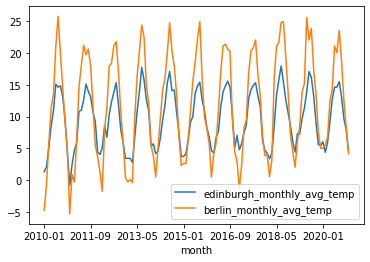

In [23]:
hypo2_df.plot()

In [24]:
"""
Solution 2:
Get monthly comparison using resampling
"""

'\nSolution 2:\nGet monthly comparison using resampling\n'

In [25]:
edinburgh_monthly_temp = edinburgh_df["avg_temp_C"].resample("M").mean()
berlin_monthly_temp = berlin_df["avg_temp_C"].resample("M").mean()

In [26]:
hypo2_df = pd.DataFrame({"edinburgh": edinburgh_monthly_temp, "berlin": berlin_monthly_temp})

In [27]:
hypo2_df

,edinburgh,berlin
date,,
2010-01-31,1.322581,-4.741935
2010-02-28,2.071429,-0.785714
2010-03-31,5.129032,5.806452
2010-04-30,8.533333,11.366667
2010-05-31,10.903226,13.419355
...,...,...
2020-08-31,15.516129,23.580645
2020-09-30,13.066667,18.666667
2020-10-31,9.677419,12.580645


In [28]:
hypo2_df.describe()

,edinburgh,berlin
count,132.000000,132.000000
mean,9.530600,11.853573
std,4.390687,8.014202
min,-0.774194,-5.322581
25%,5.682258,5.115207
50%,9.507527,11.951613
75%,13.456989,19.460484
max,17.967742,25.806452


<AxesSubplot:xlabel='date'>

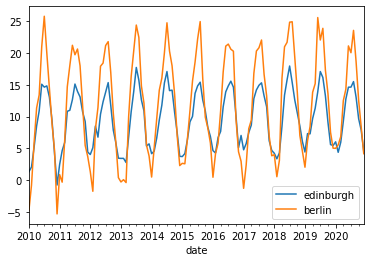

In [29]:
hypo2_df.plot()

In [41]:
"""
Rolling statistics
"""
edinburgh_df["7day_avg_temp"] = edinburgh_df["avg_temp_C"].rolling(7).mean()
edinburgh_df.dropna(inplace=True)
berlin_df["7day_avg_temp"] = berlin_df["avg_temp_C"].rolling(7).mean()
berlin_df.dropna(inplace=True)

In [44]:
rolling_df = pd.DataFrame({
        "edinburgh_7day_avg_temp": edinburgh_df["7day_avg_temp"],
        "berlin_7day_avg_temp": berlin_df["7day_avg_temp"]
    })

<AxesSubplot:xlabel='date'>

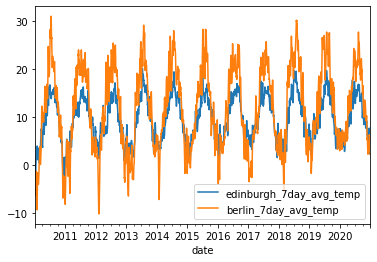

In [47]:
rolling_df.plot()